# Code for generating Figure 1

In [30]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

### Define Functions

In [31]:
def unit_vec(d):
    v = np.random.randn(d,1)
    return v/la.norm(v)

def orth_vect(v, w):
    return v-(v.T@w)*w

def dist(v, w):
    return 1-(v.T@w)**2/(v.T@v)/(w.T@w)

def orthomatrix(d, k):
    x = np.random.randn(d,k)
    x,_ = la.qr(x, mode='economic')
    return x

def twoDcca_SVD(X, Y, k1, k2, loading_init=None, regular=1e-6, iter_max=10):
    (T, mx, nx) = X.shape
    (T, my, ny) = Y.shape

    corr = np.zeros(iter_max)    
    error = np.zeros(iter_max)
    
    (Lx, Rx, Ly, Ry) = loading_init if loading_init else list(map(lambda x: np.random.randn(x, 1), (mx, nx, my, ny)))
    X_tf = twoDcca_transform(X, Lx, Rx)
    Y_tf = twoDcca_transform(Y, Ly, Ry)
    corr[0] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
    
    for i in range(iter_max):
        diff = 0
        # estimate Lx, Ly
        XR = np.matmul(X, Rx)
        YR = np.matmul(Y, Ry)
        Srxx = np.matmul(XR, XR.transpose(0,2,1)).sum(axis=0)/T
        Srxy = np.matmul(XR, YR.transpose(0,2,1)).sum(axis=0)/T
        Sryy = np.matmul(YR, YR.transpose(0,2,1)).sum(axis=0)/T
        A = np.block([[np.zeros((mx, mx)), Srxy], [Srxy.T, np.zeros((my, my))]])
        B = la.block_diag(Srxx, Sryy)+regular*np.eye(mx+my)
        (Leval, Levec) = la.eigh(A, b=B)
        diff += la.norm(Lx+Levec[:mx, :k1])
        Lx = -Levec[:mx, :k1]
        diff += la.norm(Ly-Levec[mx:, :k1])
        Ly = Levec[mx:, :k1]

        # estimate Rx, Ry
        XL = np.matmul(X.transpose(0,2,1), Lx)
        YL = np.matmul(Y.transpose(0,2,1), Ly)
        Slxx = np.matmul(XL, XL.transpose(0,2,1)).sum(axis=0)/T
        Slxy = np.matmul(XL, YL.transpose(0,2,1)).sum(axis=0)/T
        Slyy = np.matmul(YL, YL.transpose(0,2,1)).sum(axis=0)/T
        A = np.block([[np.zeros((nx, nx)), Slxy], [Slxy.T, np.zeros((ny, ny))]])
        B = la.block_diag(Slxx, Slyy)+regular*np.eye(nx+ny)
        (Reval, Revec) = la.eigh(A, b=B)
        diff += la.norm(Rx+Revec[:nx, :k2])
        Rx = -Revec[:nx, :k2]
        diff += la.norm(Ry-Revec[nx:, :k2])
        Ry = Revec[nx:, :k2]
        
        X_tf = twoDcca_transform(X, Lx, Rx)
        Y_tf = twoDcca_transform(Y, Ly, Ry)
        corr[i] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
        error[i] = diff
        
    return (Lx, Rx, Ly, Ry), corr, error

def twoDcca_transform(X, L, R):
    (N, _, _) = X.shape
    (_, k1) = L.shape
    (_, k2) = R.shape
    return (np.matmul(np.matmul(L.T, X), R)).reshape(N, k1*k2)

def _twoDcca_oneStep(ui, vi, X, Y, method, x_regular, y_regular):
    (N, p) = X.shape
    (N, q) = Y.shape

    Sxx = np.matmul(X.T, X)/N
    Sxy = np.matmul(X.T, Y)/N
    Syy = np.matmul(Y.T, Y)/N
    
    if method=='pi':
        u = la.solve((Sxx+x_regular*np.eye(p)),Sxy@vi)
        u /= np.sqrt(u.T@Sxx@u)
        du = u-ui
        v = la.solve((Syy+y_regular*np.eye(q)),Sxy.T@u)
        v /= np.sqrt(v.T@Syy@v)
        dv = v-vi
    if method=='als':
        u = la.solve((Sxx+x_regular*np.eye(p)),Sxy@vi)
        u /= la.norm(u)
        du = u-ui
        v = la.solve((Syy+y_regular*np.eye(q)),Sxy.T@u)
        v /= la.norm(v)
        dv = v-vi

    return u, v, du.T@du, dv.T@dv

def twoDcca(X, Y, method='als', loading_init=None, x_regular=1e-8, y_regular=1e-8, iter_max=10):
    (N, mx, nx) = X.shape
    (_, my, ny) = Y.shape
    
    (Lx, Rx, Ly, Ry) = loading_init if loading_init else list(map(unit_vec, (mx, nx, my, ny)))
  
    loading = [Lx, Rx, Ly, Ry]
    
    corr = np.zeros(iter_max)
    error = np.zeros(iter_max)
    
    X_tf = twoDcca_transform(X, Lx, Rx)
    Y_tf = twoDcca_transform(Y, Ly, Ry)
    corr[0] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
    
    for n in range(iter_max):
        XR = np.matmul(X, Rx)[:,:,0]
        YR = np.matmul(Y, Ry)[:,:,0]
        (Lx, Ly, dLx, dLy) = _twoDcca_oneStep(Lx, Ly, XR, YR, method, x_regular, y_regular)
        XL = np.matmul(X.transpose(0,2,1), Lx)[:,:,0]
        YL = np.matmul(Y.transpose(0,2,1), Ly)[:,:,0]
        (Rx, Ry, dRx, dRy) = _twoDcca_oneStep(Rx, Ry, XL, YL, method, x_regular, y_regular)
            
        
        X_tf = twoDcca_transform(X, Lx, Rx)
        Y_tf = twoDcca_transform(Y, Ly, Ry)
      
        loading = [Lx, Rx, Ly, Ry]
        error[n] = dLx+dLy+dRx+dRy
        corr[n] = np.corrcoef(X_tf.T, Y_tf.T)[0][1]
        
    return loading, corr, error

In [32]:
def genData_pCCA(T, mx, nx, my, ny, k, e):
    X2d = np.zeros((T, mx, nx))
    Y2d = np.zeros((T, my, ny))
    U1 = orthomatrix(mx, k)
    U2 = orthomatrix(nx, k)
    V1 = orthomatrix(my, k)
    V2 = orthomatrix(ny, k)
    for t in range(T):
        Ex = np.random.randn(k,k)
        Ey = np.random.randn(k,k)
        c = np.random.randn(1)
        Ex[0,0] = np.sqrt(1-e)*c + np.sqrt(e)*Ex[0,0]
        X2d[t,:,:] = U1@Ex@U2.T
        Ey[0,0] = np.sqrt(1-e)*c + np.sqrt(e)*Ey[0,0]
        Y2d[t,:,:] = V1@Ey@V2.T
    return X2d, Y2d, U1[:,0:1], U2[:,0:1], V1[:,0:1], V2[:,0:1]

# Simulation

In [33]:
k = 2
k1 = 2
k2 = 2
mx = 3
nx = 4
my = 4
ny = 3
d1 = 0
d2 = 0
N = 50
sigma = 1
e = 0

In [76]:
M = 100
I = 10
N = 50
corr_hopm = np.zeros((M,I))
corr_als = np.zeros((M,I))
corr_SVD = np.zeros((M,I))

error_hopm = np.zeros((M,I))
error_als = np.zeros((M,I))
error_SVD = np.zeros((M,I))



(X, Y, U1, U2, V1, V2) = genData_pCCA(N, mx, nx, my, ny, k, e)

for m in range(M):
    loading_random = list(map(lambda x: np.random.randn(x, 1), (mx, nx, my, ny)))
    
    (loading, corr, error) = twoDcca(X, Y, method='pi', iter_max=I, loading_init=loading_random)
    corr_hopm[m] = corr
    error_hopm[m] = error
    
    (loading, corr, error) = twoDcca(X, Y, method='als', iter_max=I, loading_init=loading_random)
    corr_als[m] = corr
    error_als[m] = error

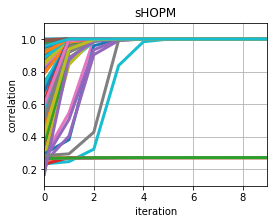

In [77]:
plt.figure(figsize=(4,3))
plt.plot(corr_als.T, linewidth=3)
plt.title("sHOPM")
plt.ylabel('correlation')
plt.xlabel('iteration')
plt.ylim(0.1,1.1)
plt.xlim(0,I-1)
plt.grid(True)
plt.savefig('corr_als.png', bbox_inches='tight')

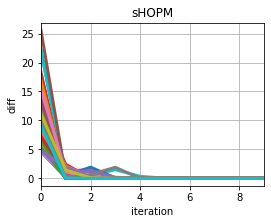

In [78]:
plt.figure(figsize=(4,3))
plt.plot(error_als.T, linewidth=3)
plt.title("sHOPM")
plt.ylabel('diff')
plt.xlabel('iteration')
plt.xlim(0,I-1)
plt.grid(True)
plt.savefig('error_als.png', bbox_inches='tight')

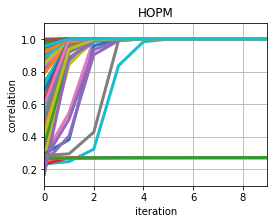

In [79]:
plt.figure(figsize=(4,3))
plt.plot(corr_hopm.T, linewidth=3)
plt.title("HOPM")
plt.ylabel('correlation')
plt.xlabel('iteration')
plt.ylim(0.1,1.1)
plt.xlim(0,I-1)
plt.grid(True)
plt.savefig('corr_hopm.png', bbox_inches='tight')

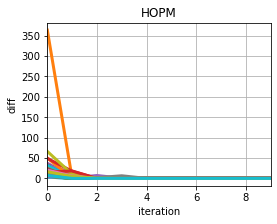

In [80]:
plt.figure(figsize=(4,3))
plt.plot(error_hopm.T, linewidth=3)
plt.title("HOPM")
plt.ylabel('diff')
plt.xlabel('iteration')
plt.xlim(0,I-1)
plt.grid(True)
plt.savefig('error_hopm.png', bbox_inches='tight')